## Classification of NHL Player Longevity

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

### Read in the Dataset 

I am using the pre-processed NHLdataset that I created in the first project for this assignment. For its cleaning, I removed all the unknown values, discrepancies in spacing, and filled the null values with 0. The position column was also eliminated, in favor of extracing a position1 and position2 title from the playername column. For names that failed to appear in searches, I applied the unidecode function to remove accented characters, making all possible searches from the american standard keyboard. The league column was dropped, as all data points are from the NHL. 

In [244]:
nhl_since_2003 = pd.read_csv('/Users/HWAT/Downloads/Code/3162 Project/project-1/nhl_since_2003.csv')

For the purpose of this assignment, I will allow athletes who did not play a game to be included in the dataset. This will matter in classification because our target will be predicting if an athlete will play in the NHL for more or less than five years. 

In [245]:
# Beginning, count the number of unique seasons per player
player_seasons = nhl_since_2003.groupby('playername')['season'].nunique().reset_index()
player_seasons.rename(columns = {'season': 'seasons played'}, inplace = True)

Finally, lets handle categorical variables and encode them : position and team

In [246]:
label_encoder = LabelEncoder()
nhl_since_2003['position1'] = label_encoder.fit_transform(nhl_since_2003['position1'].astype(str))
nhl_since_2003['position2'] = label_encoder.fit_transform(nhl_since_2003['position2'].astype(str))
nhl_since_2003['team'] = label_encoder.fit_transform(nhl_since_2003['team'].astype(str))

### Defining the Target Variable

In [247]:
# Longevity is the number of years a player has played in the NHL
# I want to classify on longevity and see if we can predict it based on the features
# I will create a new column called 'longevity' that will be the number of seasons a player has played in the NHL
player_seasons['longevity'] = player_seasons['seasons played'].apply(lambda x: '< 5 years' if x < 5 else '>= 5 years')
# Now I will merge the longevity column back into the original dataframe
nhl_since_2003 = nhl_since_2003.merge(player_seasons[['playername', 'longevity']], on='playername', how='left')

##### Now lets see how the first 5 rows of the dataset look like

In [248]:
nhl_since_2003

,Unnamed: 0,playername,season,position1,position2,team,gp,g,a,tp,ppg,pim,+/-,link,longevity
0,0,Martin St-Louis,2003-2004,4,6,29,82,38,56,94,1.15,24,35,https://www.eliteprospects.com/player/8772/mar...,>= 5 years
1,1,Ilya Kovalchuk,2003-2004,3,6,2,81,41,46,87,1.07,63,-10,https://www.eliteprospects.com/player/3660/ily...,>= 5 years
2,2,Joe Sakic,2003-2004,0,6,8,81,33,54,87,1.07,42,11,https://www.eliteprospects.com/player/8862/joe...,>= 5 years
3,3,Markus Naslund,2003-2004,3,6,32,78,35,49,84,1.08,58,24,https://www.eliteprospects.com/player/697/mark...,>= 5 years
4,4,Marian Hossa,2003-2004,4,6,22,81,36,46,82,1.01,46,4,https://www.eliteprospects.com/player/4720/mar...,>= 5 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,19939,Jesper Fast,2024-2025,4,6,6,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/10967/je...,>= 5 years
19940,19940,Gabriel Landeskog,2024-2025,3,4,8,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/10393/ga...,>= 5 years
19941,19941,T.J. Oshie,2024-2025,4,6,34,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/9209/t.j...,>= 5 years
19942,19942,Calle Jarnkrok,2024-2025,0,5,30,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/6020/cal...,>= 5 years


In [249]:
nhl_since_2003.loc[(nhl_since_2003['playername'] == 'Sebastian Aho')]

,Unnamed: 0,playername,season,position1,position2,team,gp,g,a,tp,ppg,pim,+/-,link,longevity
11663,11663,Sebastian Aho,2016-2017,0,5,6,82,24,25,49,0.60,26,-1,https://www.eliteprospects.com/player/152111/s...,>= 5 years
12514,12514,Sebastian Aho,2017-2018,0,5,6,78,29,36,65,0.83,24,4,https://www.eliteprospects.com/player/152111/s...,>= 5 years
13143,13143,Sebastian Aho,2017-2018,1,6,20,22,1,3,4,0.18,6,-5,https://www.eliteprospects.com/player/67208/se...,>= 5 years
13389,13389,Sebastian Aho,2018-2019,0,5,6,82,30,53,83,1.01,26,25,https://www.eliteprospects.com/player/152111/s...,>= 5 years
14310,14310,Sebastian Aho,2019-2020,0,5,6,68,38,28,66,0.97,26,10,https://www.eliteprospects.com/player/152111/s...,>= 5 years
15214,15214,Sebastian Aho,2020-2021,0,5,6,56,24,33,57,1.02,32,16,https://www.eliteprospects.com/player/152111/s...,>= 5 years
15890,15890,Sebastian Aho,2020-2021,1,6,20,3,1,1,2,0.67,2,-1,https://www.eliteprospects.com/player/67208/se...,>= 5 years
16164,16164,Sebastian Aho,2021-2022,0,5,6,79,37,44,81,1.03,38,18,https://www.eliteprospects.com/player/152111/s...,>= 5 years
16694,16694,Sebastian Aho,2021-2022,1,6,20,36,2,10,12,0.33,10,-6,https://www.eliteprospects.com/player/67208/se...,>= 5 years
17218,17218,Sebastian Aho,2022-2023,0,5,6,75,36,31,67,0.89,42,8,https://www.eliteprospects.com/player/152111/s...,>= 5 years


In [250]:
# Drop unnecessary columns
nhl_since_2003 = nhl_since_2003.drop(columns = ['Unnamed: 0'])
nhl_since_2003

,playername,season,position1,position2,team,gp,g,a,tp,ppg,pim,+/-,link,longevity
0,Martin St-Louis,2003-2004,4,6,29,82,38,56,94,1.15,24,35,https://www.eliteprospects.com/player/8772/mar...,>= 5 years
1,Ilya Kovalchuk,2003-2004,3,6,2,81,41,46,87,1.07,63,-10,https://www.eliteprospects.com/player/3660/ily...,>= 5 years
2,Joe Sakic,2003-2004,0,6,8,81,33,54,87,1.07,42,11,https://www.eliteprospects.com/player/8862/joe...,>= 5 years
3,Markus Naslund,2003-2004,3,6,32,78,35,49,84,1.08,58,24,https://www.eliteprospects.com/player/697/mark...,>= 5 years
4,Marian Hossa,2003-2004,4,6,22,81,36,46,82,1.01,46,4,https://www.eliteprospects.com/player/4720/mar...,>= 5 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,Jesper Fast,2024-2025,4,6,6,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/10967/je...,>= 5 years
19940,Gabriel Landeskog,2024-2025,3,4,8,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/10393/ga...,>= 5 years
19941,T.J. Oshie,2024-2025,4,6,34,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/9209/t.j...,>= 5 years
19942,Calle Jarnkrok,2024-2025,0,5,30,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/6020/cal...,>= 5 years


### Defining the Features and the Target Variable

In [251]:
features = ['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-', 'position1', 'position2', 'team']
X = nhl_since_2003[features]
y = nhl_since_2003['longevity']

In [252]:
# Split the data into training and testing sets - 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Standardizing numeric columns with StantandardScaler

In [253]:
# To X_train and X_test - they only contain the numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Random Forest Classifier

In [254]:
# Create a Random Forest Classifier with 100 trees and fit it to the training data
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [255]:
# Make predictions on the testing data
y_pred = rf_clf.predict(X_test)

In [256]:
# Evaluate the Model Performance
accuracy_score_rf = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_score_rf:.2f}')
# Print the classification report
print("Classification Report: \n", classification_report(y_test, y_pred))
# Print the confusion matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
# Create a DataFrame to store the feature importances
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf_clf.feature_importances_})
# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Print the feature importances
print("Feature Importances: \n", feature_importances)

Accuracy: 0.82
Classification Report: 
               precision    recall  f1-score   support

   < 5 years       0.59      0.40      0.48       801
  >= 5 years       0.86      0.93      0.89      3188

    accuracy                           0.82      3989
   macro avg       0.73      0.66      0.69      3989
weighted avg       0.81      0.82      0.81      3989

Confusion Matrix: 
 [[ 319  482]
 [ 218 2970]]
Feature Importances: 
      Feature  Importance
0         gp    0.186836
9       team    0.171751
5        pim    0.120807
6        +/-    0.118799
4        ppg    0.089252
3         tp    0.083566
2          a    0.079325
1          g    0.060298
7  position1    0.048999
8  position2    0.040368


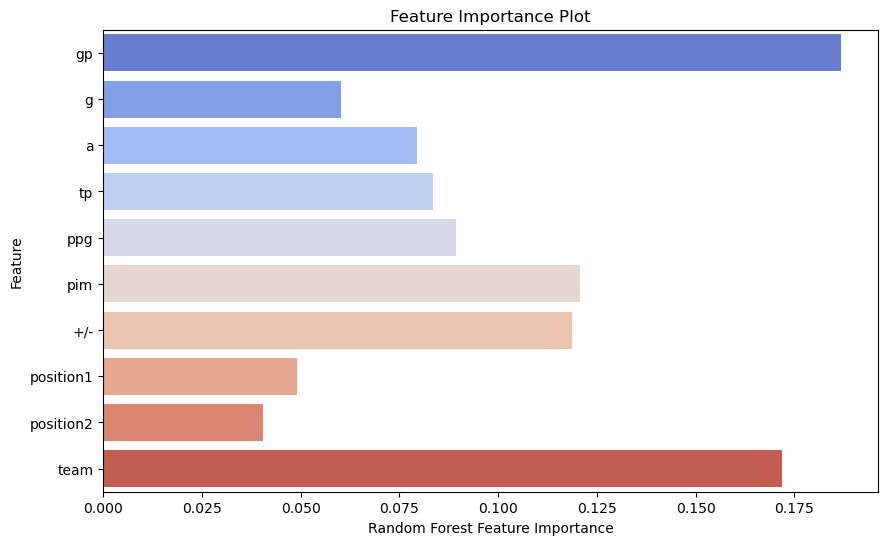

In [257]:
# Creating a feature importance plot
feature_importances = rf_clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette='coolwarm')
plt.xlabel('Random Forest Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

### Support Vector Machine Classifier - We can expect this part of the notebook to take longer time running because of the size of the data we are working with

In [258]:
# Create a SVM Classifier with a radial basis function kernel and fit it to the training data
svm_clf = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [259]:
# Make predictions on the testing data
y_pred_svm = svm_clf.predict(X_test)

In [260]:
# Evaluate the Model Performance
accuracy_score_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy_score_svm:.2f}')
# Print the classification report
print("Classification Report: \n", classification_report(y_test, y_pred_svm))
# Print the confusion matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_svm))

Accuracy: 0.72
Classification Report: 
               precision    recall  f1-score   support

   < 5 years       0.39      0.74      0.51       801
  >= 5 years       0.92      0.71      0.80      3188

    accuracy                           0.72      3989
   macro avg       0.65      0.73      0.66      3989
weighted avg       0.81      0.72      0.74      3989

Confusion Matrix: 
 [[ 592  209]
 [ 911 2277]]


##### Opting to calculate permutation importance instead of feature importance, kernel is not linearly separableble, hence feature importance is not applicable. Might take a long time to run

In [261]:
results_svm = permutation_importance(svm_clf, X_test, y_test, n_repeats=10, random_state=42)

In [262]:
# Similar to feature importance, we create a DataFrame to store the permutation importances
feature_importances_svm = pd.DataFrame({'Feature': features, 'Importance': results_svm.importances_mean})
# Sort the DataFrame by importance in descending order
feature_importances_svm = feature_importances_svm.sort_values(by='Importance', ascending=False)
# Print the top 10 features
print(feature_importances_svm)

     Feature  Importance
0         gp    0.020055
7  position1    0.016245
8  position2    0.010178
5        pim    0.007145
9       team    0.000827
4        ppg   -0.000777
6        +/-   -0.001504
1          g   -0.012911
2          a   -0.013111
3         tp   -0.014791


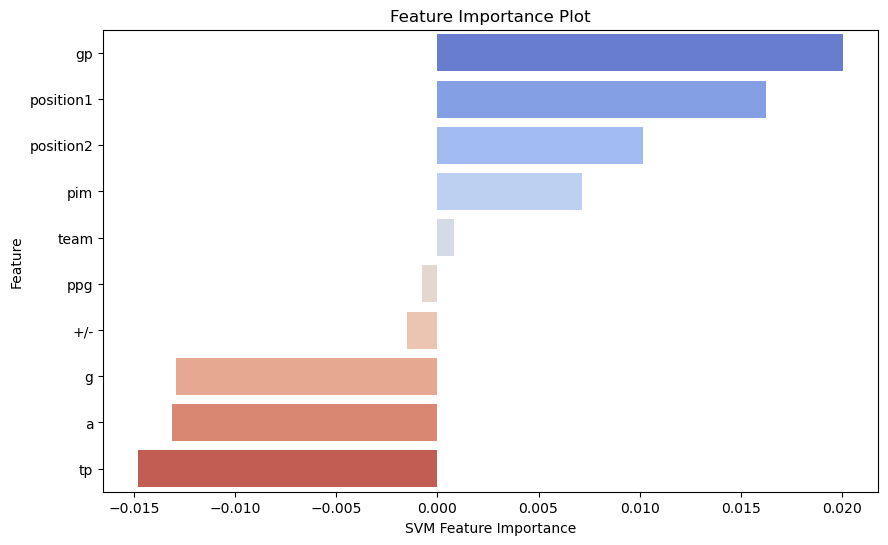

In [263]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_svm['Importance'], y=feature_importances_svm['Feature'], palette='coolwarm')
plt.xlabel('SVM Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

### Gradient Boosting Classifier

In [264]:
# Create a Gradient Boosting Classifier and fit it to the training data
gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=42)

In [265]:
# Fit the Gradient Boosting Classifier to the training data
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=150, random_state=42)

In [266]:
# Make predictions on the testing data using the Gradient Boosting Classifier
y_pred_gbc = gb_clf.predict(X_test)

In [267]:
# Evaluate the Model Performance
accuracy_score_gbc = accuracy_score(y_test, y_pred_gbc)
print(f'Accuracy: {accuracy_score_gbc:.2f}')
# Print the classification report
print("Classification Report: \n", classification_report(y_test, y_pred_gbc))
# Print the confusion matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_gbc))
# Create a DataFrame to store the feature importances
feature_importances_gbc = pd.DataFrame({'Feature': features, 'Importance': gb_clf.feature_importances_})
# Sort the DataFrame by importance in descending order
feature_importances_gbc = feature_importances_gbc.sort_values(by='Importance', ascending=False)
# Print the feature importances
print("Feature Importances: \n", feature_importances_gbc)

Accuracy: 0.80
Classification Report: 
               precision    recall  f1-score   support

   < 5 years       0.52      0.30      0.38       801
  >= 5 years       0.84      0.93      0.88      3188

    accuracy                           0.80      3989
   macro avg       0.68      0.61      0.63      3989
weighted avg       0.78      0.80      0.78      3989

Confusion Matrix: 
 [[ 239  562]
 [ 221 2967]]
Feature Importances: 
      Feature  Importance
0         gp    0.568982
3         tp    0.191297
2          a    0.049149
9       team    0.044409
5        pim    0.041878
6        +/-    0.028180
4        ppg    0.027459
7  position1    0.027287
8  position2    0.016644
1          g    0.004716


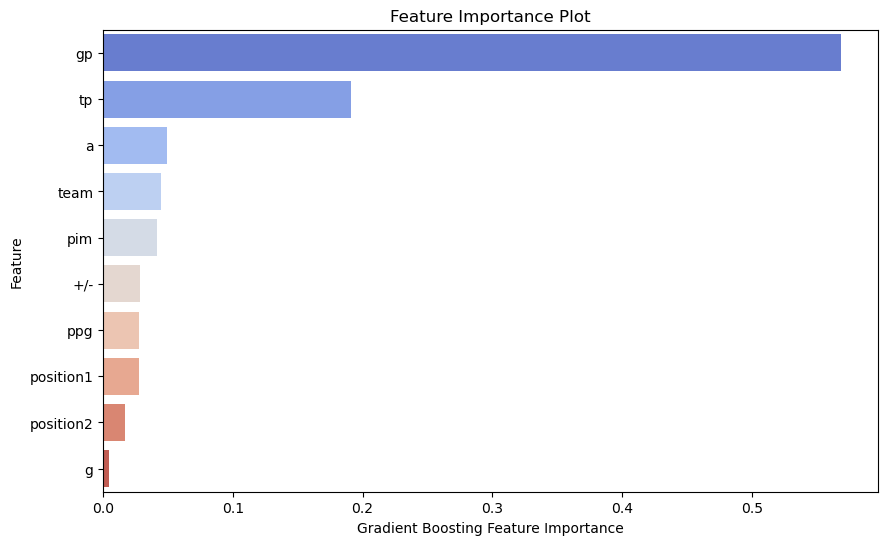

In [268]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_gbc['Importance'], y=feature_importances_gbc['Feature'], palette='coolwarm')
plt.xlabel('Gradient Boosting Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

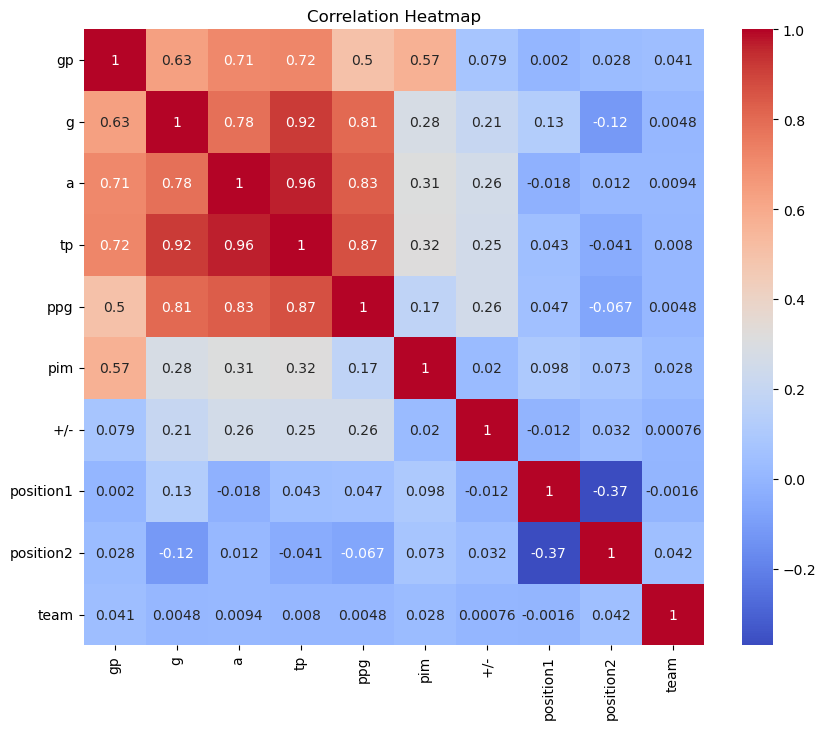

In [269]:
# Heat map for key features to reveal relationships between variables - games played and career longevity
nhl_numeric = nhl_since_2003[features]
correlation_matrix = nhl_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

/var/folders/nk/xkn2b48n3qqgck2_67t54gym0000gq/T/ipykernel_53997/1014479514.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(nhl_since_2003['longevity'], palette='coolwarm')


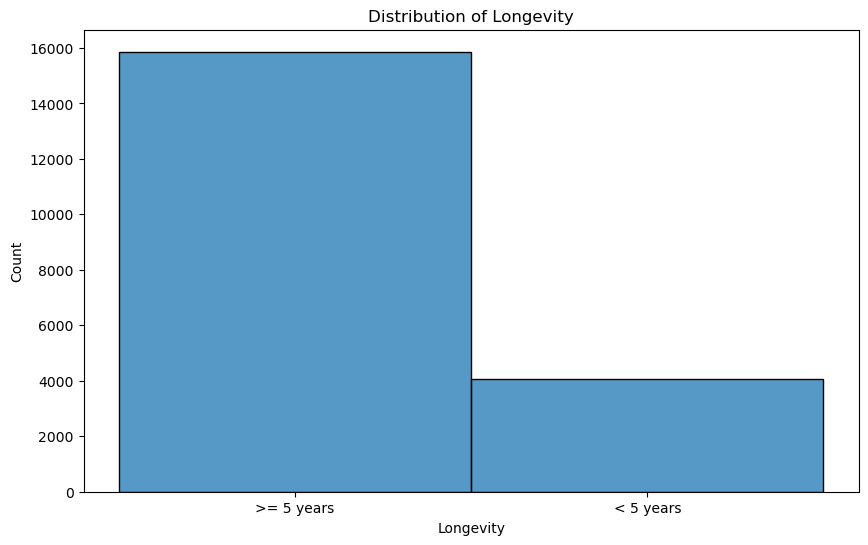

In [272]:
# Create a histogram to visualize the distribution of longevity
plt.figure(figsize=(10, 6))
sns.histplot(nhl_since_2003['longevity'], palette='coolwarm')
plt.xlabel('Longevity')
plt.ylabel('Count')
plt.title('Distribution of Longevity')
plt.show()

In [ ]:
nhl_since_2003

,playername,season,position1,position2,team,gp,g,a,tp,ppg,pim,+/-,link,seasons played,longevity
0,Martin St-Louis,2003-2004,4,6,29,82,38,56,94,1.15,24,35,https://www.eliteprospects.com/player/8772/mar...,12,< 5 years
1,Ilya Kovalchuk,2003-2004,3,6,2,81,41,46,87,1.07,63,-10,https://www.eliteprospects.com/player/3660/ily...,12,< 5 years
2,Joe Sakic,2003-2004,0,6,8,81,33,54,87,1.07,42,11,https://www.eliteprospects.com/player/8862/joe...,6,< 5 years
3,Markus Naslund,2003-2004,3,6,32,78,35,49,84,1.08,58,24,https://www.eliteprospects.com/player/697/mark...,6,< 5 years
4,Marian Hossa,2003-2004,4,6,22,81,36,46,82,1.01,46,4,https://www.eliteprospects.com/player/4720/mar...,18,< 5 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,Jesper Fast,2024-2025,4,6,6,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/10967/je...,12,< 5 years
19940,Gabriel Landeskog,2024-2025,3,4,8,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/10393/ga...,14,< 5 years
19941,T.J. Oshie,2024-2025,4,6,34,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/9209/t.j...,17,< 5 years
19942,Calle Jarnkrok,2024-2025,0,5,30,0,0,0,0,0.00,0,0,https://www.eliteprospects.com/player/6020/cal...,12,< 5 years


In [ ]:
nhl_since_2003.to_csv('nhl_since_2003_long.csv')